Enfoque del dataset de Dipromats basado en RNN con BiLSTM

In [ ]:
### IMPORTS ###
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical

import matplotlib.pyplot as plt

from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences

import tensorflow as tf
tf.random.set_seed(55) # para asegurar experimentos son reproducibles
from keras.models import Sequential
from keras.layers import Embedding, Bidirectional, LSTM, Dropout, Dense
from keras.callbacks import ModelCheckpoint, EarlyStopping

from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import gensim.downloader as api

import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk.stem.porter import PorterStemmer
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
import re

!pip install textaugment
from textaugment import EDA

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.1/55.1 kB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 25.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 414.7 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.6/53.6 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.0/65.0 kB 8.1 MB/s eta 0:00:00
  Created wheel for googletrans: filename=googletrans-3.0.0-py3-none-any.whl size=15721 sha256=ea2dd1e4bc30a0c9b97a73ada15005be2db477c57e187e9feae3a983594a402d
  Stored in directory: /root/.cache/pip/wheels/b3/81/ea/8b030407f8ebfc2f857814e086bb22ca2d4fea1a7be63652ab
Successfully built googletrans
  Attempting uninstall: chardet
    Found existing installation: chardet 4.0.0
    Uninstalling chard

# Cargar Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

PATH = "/content/drive/My Drive/TFM/Data/Dipromats/"

Mounted at /content/drive


In [ ]:
### CONJUNTOS DE ENTRENAMIENTO, VALIDACIÓN Y TEST ###
df = pd.read_json(PATH + "train_es.json",  encoding='utf-8', encoding_errors='ignore')
df = df[['text', 'label_task1']]
df = df.rename(columns={"text": "Text", "label_task1": "Label"})
df.fillna(" ", inplace=True)

X_train = df['Text']
y_train = df['Label']

X_train, X_aux, y_train, y_aux = train_test_split(X_train, y_train, test_size=0.3, random_state=55, stratify=y_train)
X_val, X_test, y_val, y_test = train_test_split(X_aux, y_aux, test_size=0.66, random_state=55, stratify=y_aux)

X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)

print('Tamaño conjunto de Entrenamiento:', len(X_train))
print('Tamaño conjunto de Validación:', len(X_val))
print('Tamaño conjunto de Evaluación:', len(X_test))

Tamaño conjunto de Entrenamiento: 4284
Tamaño conjunto de Validación: 624
Tamaño conjunto de Evaluación: 1212


# Preprocesamiento y Limpieza

In [ ]:
### LIMPIEZA DE TEXTOS ###
stopwords_es = stopwords.words("spanish")
def clean_text(text):
    # transformar a minúscula
    text=str(text).lower()
    # tokenizar
    tokens=word_tokenize(text)
    # borrar stopwords
    tokens = [word for word in tokens if word not in stopwords_es]
    # usar los stems
    tokens = [PorterStemmer().stem(word) for word in tokens]
    # eliminamos las palabras con menos de 2 caráceres
    # ignoramos cualquier palabra que contenga un digito o un símbolo especial
    min_length = 2
    p = re.compile('^[a-zA-Z]+$');
    filtered_tokens=""
    for token in tokens:
        if len(token)>=min_length and p.match(token):
            filtered_tokens = filtered_tokens + str(token) + " "

    if filtered_tokens == "":
        return "nada"
    else:
        return filtered_tokens

for index in X_train.index:
    X_train[index] = clean_text(X_train[index])

# Data Augmentation

In [ ]:
t = EDA()

x = 0
for i in range(2136):
    text = str(X_train[i])

    #new_text = t.synonym_replacement(text)
    #X_train = X_train.append(pd.Series([new_text]), ignore_index=True)
    #y_train = y_train.append(pd.Series([y_train[i]]), ignore_index=True)

    if x == 0:
        new_text = t.random_swap(text)
        X_train = X_train.append(pd.Series([new_text]), ignore_index=True)
        y_train = y_train.append(pd.Series([y_train[i]]), ignore_index=True)
    else:
        new_text = t.random_deletion(text, p=0.2)
        X_train = X_train.append(pd.Series([new_text]), ignore_index=True)
        y_train = y_train.append(pd.Series([y_train[i]]), ignore_index=True)

    x = x + 1
    if x == 2:
        x = 0

print('Tamaño conjunto de Entrenamiento:', len(X_train))

<ipython-input-5-a646eb4e07ef>:13: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(pd.Series([new_text]), ignore_index=True)
<ipython-input-5-a646eb4e07ef>:14: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series([y_train[i]]), ignore_index=True)
<ipython-input-5-a646eb4e07ef>:17: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(pd.Series([new_text]), ignore_index=True)
<ipython-input-5-a646eb4e07ef>:18: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series([y_train[i]]), ignore_index=True)


Tamaño conjunto de Entrenamiento: 6420


# Label Encoding

In [ ]:
### LABEL ENCODING ###
y_train = y_train.tolist()
y_val = y_val.tolist()
y_test = y_test.tolist()

LABELS = sorted(set(y_train))
NUM_LABELS = len(LABELS)

idx2label={}
label2idx={}
for index, label in enumerate(LABELS):
    label2idx.update([(label, index)])
    idx2label.update([(index, label)])

print('Labels:', label2idx)
le = LabelEncoder()

y_train = le.fit_transform(y_train)
y_train_cat = to_categorical(y_train)
y_val = le.fit_transform(y_val)
y_val_cat = to_categorical(y_val)
y_test = le.fit_transform(y_test)
y_test_cat = to_categorical(y_test)

Labels: {False: 0, True: 1}


# Tokenización

In [ ]:
tokenizer = Tokenizer(oov_token = True)
tokenizer.fit_on_texts(X_train)
tokenizer.word_index['<PAD>'] = 0

NUM_WORDS=len(tokenizer.word_index)
print("Tamaño del vocabulario = {}".format(NUM_WORDS))

MAX_LEN = 50 # longitud de la secuencia
encoded_train = pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen = MAX_LEN, padding='post')
encoded_val = pad_sequences(tokenizer.texts_to_sequences(X_val), maxlen = MAX_LEN, padding='post')
encoded_test = pad_sequences(tokenizer.texts_to_sequences(X_test), maxlen = MAX_LEN, padding='post')

Tamaño del vocabulario = 10455


# Matriz de Embedding

In [ ]:
#model_we = api.load("glove-wiki-gigaword-50")       #EMBED_SIZE = 50
#model_we = api.load("glove-twitter-200")          #EMBED_SIZE = 200
#model_we = api.load("word2vec-google-news-300")     #EMBED_SIZE = 300

model_we = api.load("word2vec-google-news-300")
EMBED_SIZE = 300

# creamos una matriz para los textos del conjunto de entrenamiento
embedding_matrix = np.zeros((NUM_WORDS, EMBED_SIZE))
for word, i in tokenizer.word_index.items():
    try:
        embedding_vector = model_we[word]
        # word embedding para la palabra con índice i
        embedding_matrix[i] = embedding_vector
    except:
        #if word does not exist, we do not udpate the matrix
        pass

[=================================================-] 99.8% 1659.9/1662.8MB downloaded


# **BiLSTM**

In [ ]:
EMBEDDING_SIZE = EMBED_SIZE
DROPOUT = 0.4

model = Sequential()
# capa donde se crea la matriz de word embeddings
# Cada token está asociado con un entero (gracias a la tokenización)
# Cada entero está asociado a un vector de la matriz
# Las secuencias se representan con estos vectores
model.add(Embedding(NUM_WORDS, EMBEDDING_SIZE, input_length=MAX_LEN, weights=[embedding_matrix]))

model.add(Bidirectional(LSTM(100, return_sequences=True, recurrent_dropout=0.2)))
# Añadimos una capaz droput después de la capa bilstm
model.add(Dropout(DROPOUT))

model.add(Bidirectional(LSTM(50, recurrent_dropout=0.2)))
model.add(Dropout(DROPOUT))

model.add(Dense(50, activation='relu'))
model.add(Dense(NUM_LABELS, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

earlyStopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=0, mode='auto')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 300)           3136500   
                                                                 
 bidirectional (Bidirectiona  (None, 50, 200)          320800    
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 50, 200)           0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 100)              100400    
 nal)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 100)               0         
                                                                 
 dense (Dense)               (None, 50)                5

# Training

In [ ]:
epochs = 10 # número de veces que pasamos sobre el conjunto de aprendizaje
batch_size = 16

# training
history=model.fit(encoded_train, y_train_cat, batch_size=batch_size, epochs=epochs, validation_data=(encoded_val, y_val_cat), callbacks=[earlyStopping])


Epoch 1/10
402/402 [==============================] - 347s 823ms/step - loss: 0.3695 - accuracy: 0.8489 - val_loss: 0.5229 - val_accuracy: 0.7196
Epoch 2/10
402/402 [==============================] - 317s 789ms/step - loss: 0.1251 - accuracy: 0.9579 - val_loss: 0.6537 - val_accuracy: 0.6683
Epoch 3/10
402/402 [==============================] - 305s 758ms/step - loss: 0.0417 - accuracy: 0.9894 - val_loss: 1.4203 - val_accuracy: 0.5449
Epoch 4/10
402/402 [==============================] - 308s 765ms/step - loss: 0.0229 - accuracy: 0.9945 - val_loss: 1.0905 - val_accuracy: 0.5994


# Curvas de Aprendizaje

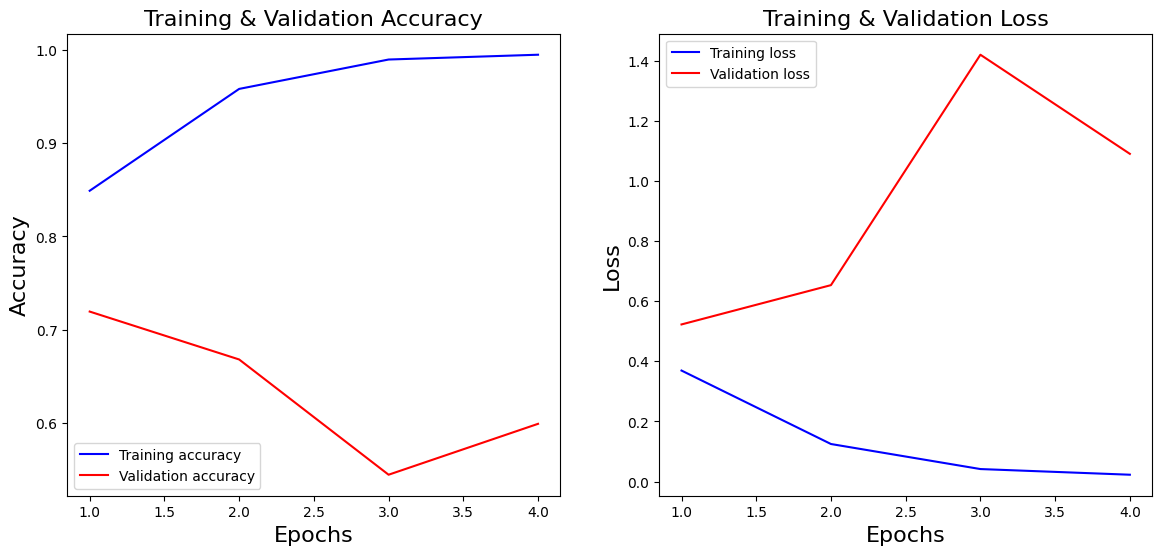

In [ ]:
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
accuracy = history_dict['accuracy']
val_accuracy = history_dict['val_accuracy']

epochs = range(1, len(loss_values) + 1)
fig, ax = plt.subplots(1, 2, figsize=(14, 6))
#
# Plot the model accuracy vs Epochs
#
ax[0].plot(epochs, accuracy, 'b', label='Training accuracy')
ax[0].plot(epochs, val_accuracy, 'red', label='Validation accuracy')
ax[0].set_title('Training & Validation Accuracy', fontsize=16)
ax[0].set_xlabel('Epochs', fontsize=16)
ax[0].set_ylabel('Accuracy', fontsize=16)
ax[0].legend()
#
# Plot the loss vs Epochs
#
ax[1].plot(epochs, loss_values, 'b', label='Training loss')
ax[1].plot(epochs, val_loss_values, 'red', label='Validation loss')
ax[1].set_title('Training & Validation Loss', fontsize=16)
ax[1].set_xlabel('Epochs', fontsize=16)
ax[1].set_ylabel('Loss', fontsize=16)
ax[1].legend()

# Evaluación

In [14]:
loss, accuracy = model.evaluate(encoded_test, y_test_cat, batch_size=batch_size)

y_pred = np.argmax(model.predict(encoded_test), axis=1)
print('Accuracy:', accuracy_score(y_test, y_pred))

print(classification_report(y_test, y_pred, target_names=['0','1']))

38/38 [==============================] - 7s 186ms/step
Accuracy: 0.5998349834983498
              precision    recall  f1-score   support

           0       0.88      0.58      0.70       974
           1       0.28      0.66      0.39       238

    accuracy                           0.60      1212
   macro avg       0.58      0.62      0.55      1212
weighted avg       0.76      0.60      0.64      1212



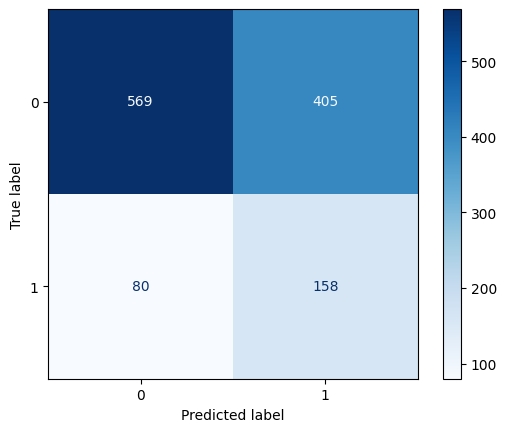

In [15]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['0','1'])
disp.plot(cmap=plt.cm.Blues,values_format='g')